In [1]:
#import library
import tensorflow as tf

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns

import plotly.express as px

from pathlib import Path  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
#load data
possitive_dir = Path('E:/My file/File in here/archive/Positive')
negative_dir = Path('E:/My file/File in here/archive/Negative')


In [3]:
#Create DataFrames
def generate_df(image_dir, label):
	filepaths = pd.Series(list(image_dir.glob(r'*.jpg')),name='Filepath').astype(str)
	labels = pd.Series(label, name='Label', index=filepaths.index)

	df = pd.concat([filepaths, labels], axis=1)
	return df

possitive_df = generate_df(possitive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([possitive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(all_df)

train_df, test_df = train_test_split(
	all_df.sample(6000, random_state=1),
	train_size=0.7,
	shuffle=True,
	random_state=1
)

print(train_df)
print(test_df)

                                                Filepath     Label
0      E:\My file\File in here\archive\Positive\03842...  POSITIVE
1      E:\My file\File in here\archive\Positive\12899...  POSITIVE
2      E:\My file\File in here\archive\Positive\15033...  POSITIVE
3      E:\My file\File in here\archive\Negative\16782...  NEGATIVE
4      E:\My file\File in here\archive\Positive\09202...  POSITIVE
...                                                  ...       ...
39995  E:\My file\File in here\archive\Positive\07814...  POSITIVE
39996  E:\My file\File in here\archive\Negative\12512...  NEGATIVE
39997  E:\My file\File in here\archive\Positive\05193...  POSITIVE
39998  E:\My file\File in here\archive\Positive\12173...  POSITIVE
39999  E:\My file\File in here\archive\Negative\13004...  NEGATIVE

[40000 rows x 2 columns]
                                                Filepath     Label
30189  E:\My file\File in here\archive\Negative\05491...  NEGATIVE
8931   E:\My file\File in here\archi

In [5]:
#Loading image data

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
	rescale=1./255,
	validation_split=0.2
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
	rescale=1./255
)

train_data = train_gen.flow_from_dataframe(
	train_df,
	x_col='Filepath',
	y_col='Label',
	target_size=(120,120),
    classes=['NEGATIVE','POSITIVE'],
	color_mode='grayscale',
	class_mode='binary',
	batch_size=32,
	shuffle=True,
	seed=42,
	subset='training'
)

val_data = train_gen.flow_from_dataframe(
	train_df,
	x_col='Filepath',
	y_col='Label',
	target_size=(120,120),
	color_mode='grayscale',
    classes=['NEGATIVE','POSITIVE'],
	class_mode='binary',
	batch_size=32,
	shuffle=True,
	seed=42,
	subset='validation'
)

test_data = test_gen.flow_from_dataframe(
	test_df,
	x_col='Filepath',
	y_col='Label',
	target_size=(120,120),
	color_mode='grayscale',
    classes=['NEGATIVE','POSITIVE'],
	class_mode='binary',
	batch_size=32,
	shuffle=False,
	seed=42
)


Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


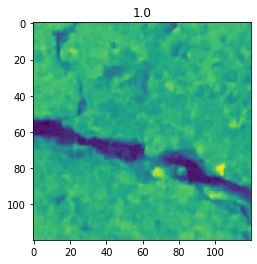

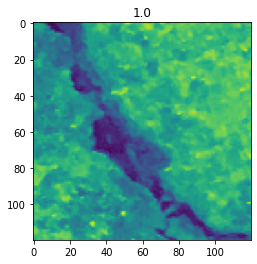

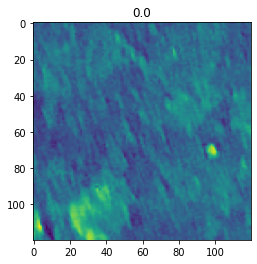

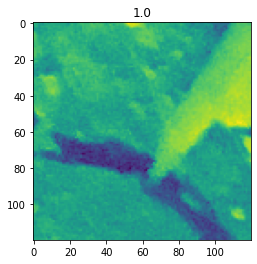

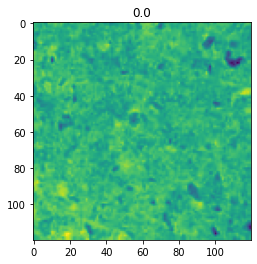

In [129]:
#Show the image with classes
for _ in range(len(train_data.filenames)-3355) :
     image, Label = train_data.next()
     # display the image from the iterator
     plt.imshow(image[0])
     Label_name=Label[0] # note you are only showing the first image of the batch
     plt.title(Label_name)
     plt.show()

In [6]:
#Training
inputs = tf.keras.Input(shape=(120,120,1))
x=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x=tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs,outputs=outputs)

model.compile(
	optimizer='adam',
	loss='binary_crossentropy',
	metrics=['accuracy']
)

print(model.summary())

history = model.fit(
	train_data,
	validation_data=val_data,
	epochs=100,
	callbacks=[
		tf.keras.callbacks.EarlyStopping(
			monitor='val_loss',
			patience=3,
			restore_best_weights=True
		)
	]

)


fig = px.line(
	history.history,
	y=['loss', 'val_loss'],
	labels={'index':"Epoch",'value':"Loss"},
	title="Training and Validation Loss Over Time"
)


fig.show()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

Test Loss: {:.5f}% 0.08527310192584991
Test Accuracy: {:.2f}% 97.7222204208374
57/57 [==============================] - 4s 73ms/step


C:\Users\danh\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



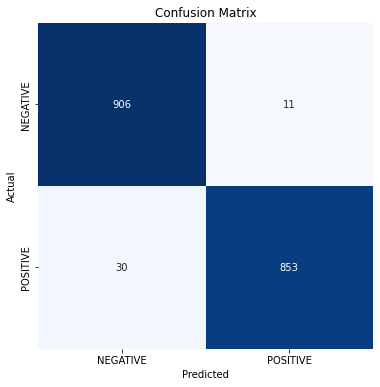

Classificationn Report:
--------------               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       917
    POSITIVE       0.99      0.97      0.98       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [7]:
#Results

def evaluate_model(model, test_data):
	results = model.evaluate(test_data, verbose=0)
	loss = results[0]
	acc = results[1]

	print("Test Loss: {:.5f}%",format(loss))
	print("Test Accuracy: {:.2f}%",format(acc*100))

	y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
	cm = confusion_matrix(test_data.labels, y_pred)
	clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE","POSITIVE"])

	plt.figure(figsize=(6,6))
	sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
	plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE","POSITIVE"])
	plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE","POSITIVE"])
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.title("Confusion Matrix")
	plt.show()

	print("Classificationn Report:\n--------------", clr)

evaluate_model(model, test_data)


In [271]:
from tensorflow.keras.preprocessing import image
iname = 'E:/My file/File in here/archive/images (2).jpg'


img = image.load_img(iname, target_size=(120, 120))

In [272]:
gray=tf.image.rgb_to_grayscale(
    img, name=None
)

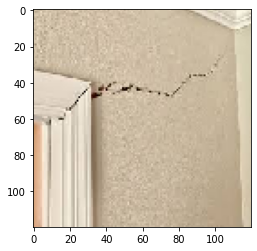

In [273]:
plt.imshow(img)


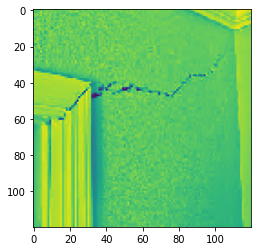

In [274]:
plt.imshow(gray)

In [275]:
img_array = image.img_to_array(gray)
img_batch = np.expand_dims(img_array, axis=0)

In [276]:
img_preprocessed=img_batch/255

In [277]:
prediction = model.predict(np.array(img_preprocessed))

1/1 [==============================] - 0s 50ms/step


In [247]:
classes=["NEGATIVE","POSITIVE"]

In [248]:
classes_index=[0,1]

In [280]:
rounded = np.round(prediction)

In [281]:
if rounded[0] == 1:print(classes[1], ':' ,  np.round(prediction*100,decimals=2), '%')
else : print(classes[0], ':' ,100-np.round(prediction*100,decimals=2), '%')

POSITIVE : [[98.5]] %
